In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
plt.rcParams['font.size'] = 24

Using TensorFlow backend.


In [20]:
df = pd.read_csv('../data/WEEK_2_DESCRIPTIONS.csv').drop('Unnamed: 0', axis=1)

In [21]:
def bin_scores(score):
    if score > 60:
        if score > 75:
            return 2
        return 1
    return 0

df['success'] = df['Critic_Score'].apply(bin_scores)

def clean_text(text):
    
    # Removes punctuation
    words = [''.join(ch for ch in s if ch not in string.punctuation)\
             for s in text.split()]
    
    # Returns the lower-case string
    return ' '.join(words).lower()

df.plots = df.plots.apply(clean_text)

In [22]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df.plots.apply(tokenizer.tokenize)

In [23]:
cv = CountVectorizer()
X_train, X_test, y_train, y_test = train_test_split(df.plots, df.success, random_state=1)
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)


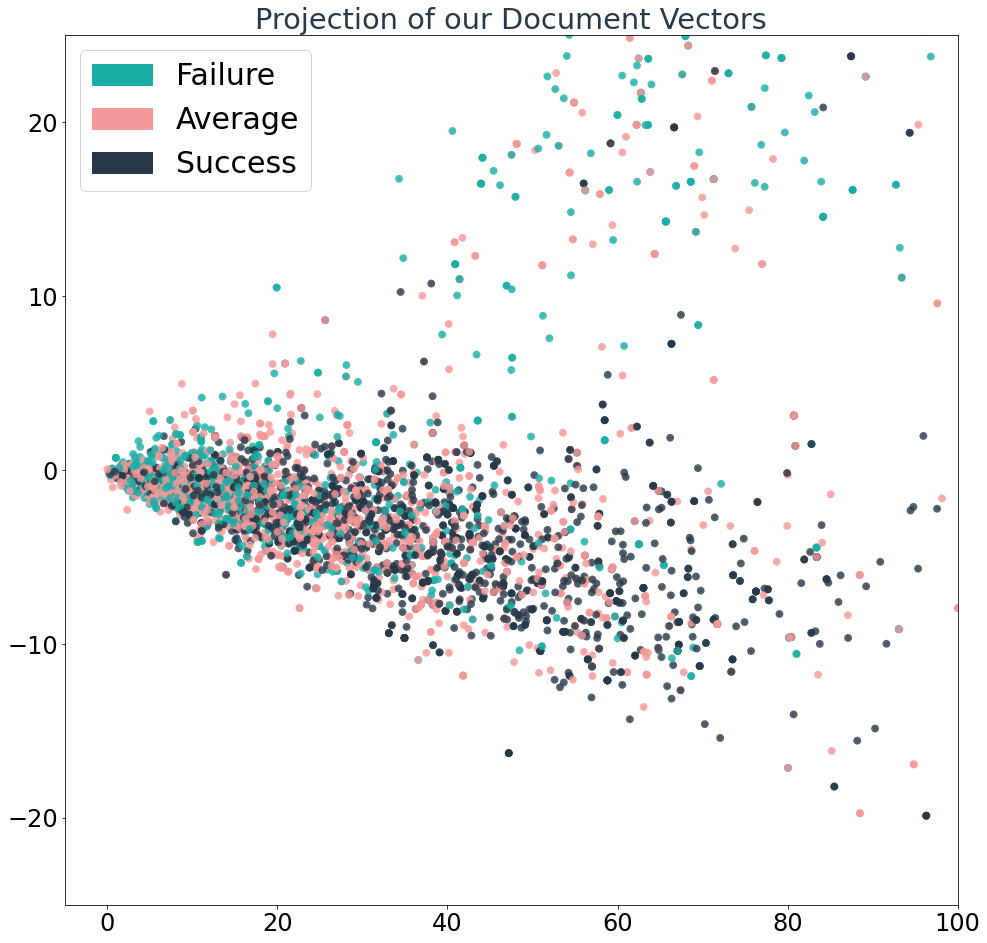

In [7]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib


def plot_LSA(test_data, test_labels, savepath="../reports/figures/PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['#1AAEA6','#F59899','#273948']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors),
                       linewidth=5)
            plt.rc_context({'axes.edgecolor':'#273948', 'xtick.color':'#273948', 'ytick.color':'#273948', 'figure.facecolor':'white'})

            red_patch = mpatches.Patch(color='#1AAEA6', label='Failure')
            green_patch = mpatches.Patch(color='#F59899', label='Average')
            third_patch = mpatches.Patch(color='#273948', label='Success')
            plt.legend(handles=[red_patch, green_patch,third_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.rc_context({'axes.edgecolor':'#273948', 'xtick.color':'#273948', 'ytick.color':'#273948', 'figure.facecolor':'white'})
plt.ylim((-25,25))
plt.xlim((-5,100))
plt.grid(False)
plt.title('Projection of our Document Vectors', color='#273948')
plt.savefig('../src/figures/dimensionality.png')
plt.show()

In [26]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [27]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.641, precision = 0.645, recall = 0.641, f1 = 0.643


In [10]:
tf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tf.fit_transform(X_train)
X_test_tfidf = tf.transform(X_test)

In [11]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [12]:

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.653, precision = 0.652, recall = 0.653, f1 = 0.652


In [13]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(tf, clf_tfidf, 10)

In [14]:
importance
clf_tfidf.coef_

array([[ 0.28860162, -0.26612528,  0.36047215, ..., -0.17718076,
         0.15416224, -0.17718076],
       [-0.44777899,  0.47542078, -0.22796392, ..., -0.19105761,
        -0.09697327, -0.19105761],
       [ 0.15917737, -0.2092955 , -0.13250823, ...,  0.36823836,
        -0.05718898,  0.36823836]])

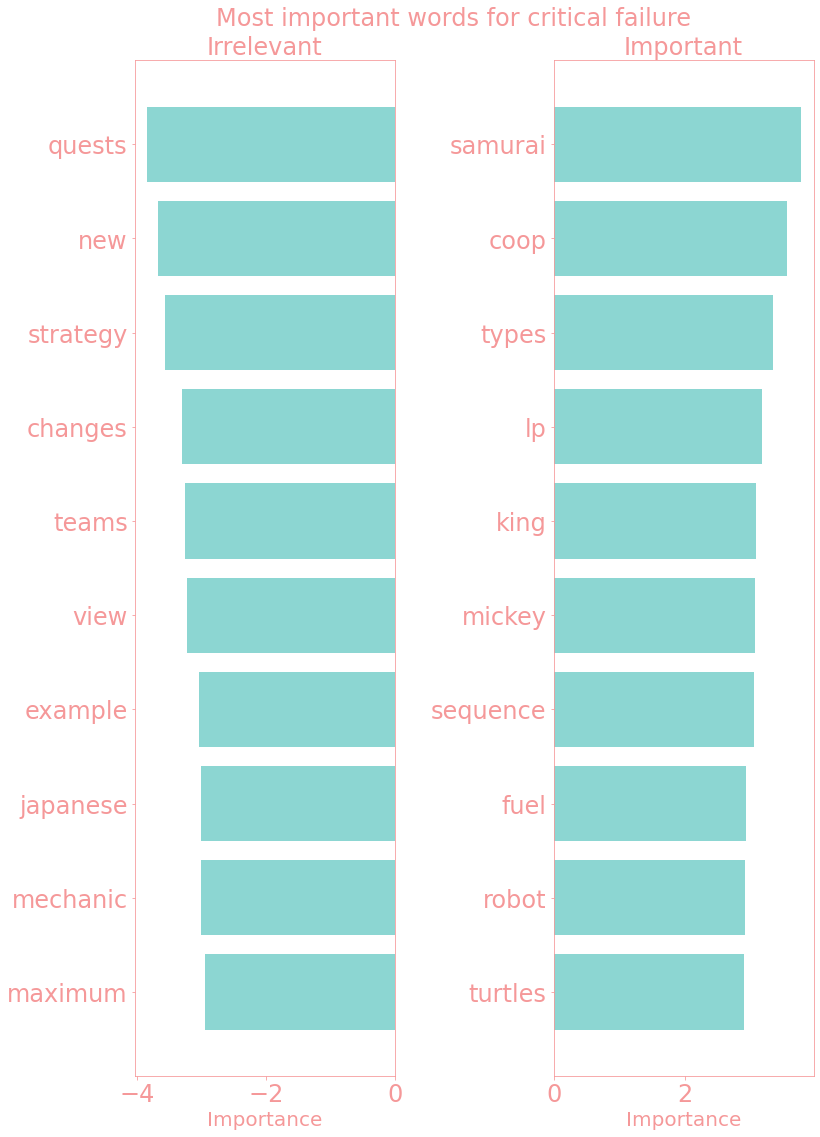

In [15]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(12,16))
    plt.rc_context({'axes.edgecolor':'#F59899', 'xtick.color':'#F59899', 'ytick.color':'#F59899', 'figure.facecolor':'white'})

    plt.subplot(121)
    plt.grid(False)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5,  color='#1AAEA6')
    plt.title('Irrelevant', fontsize=24, color='#F59899')
    plt.yticks(y_pos, bottom_words, fontsize=24)
    plt.suptitle('Key words', fontsize=16, y=1.2)
    plt.xlabel('Importance', fontsize=20, color='#F59899')
    
    plt.subplot(122)
    plt.grid(False)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5,  color='#1AAEA6')
    plt.title('Important', fontsize=24, color='#F59899')
    plt.yticks(y_pos, top_words, fontsize=24)
    plt.suptitle(name, fontsize=24, color='#F59899', y=1, x=.55)
    plt.xlabel('Importance', fontsize=20, color='#F59899')
    
    
    plt.subplots_adjust(wspace=0.8)
    plt.tight_layout(pad=1.2)
    plt.savefig('../src/figures/word_importances.png', transparent=True)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for critical failure")

In [1]:
import gensim
import pickle
import bz2

In [33]:
word2vec_path = 'http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_win10_500d.txt.bz2'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, limit=1000000)

In [34]:
len(word2vec['game'])

500

In [35]:

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=500):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [36]:

embeddings = get_word2vec_embeddings(word2vec, df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, df.success, 
                                                                                        test_size=0.2, random_state=40)

In [37]:
len(embeddings[0])

500

In [67]:

clf_w2v = LogisticRegression(penalty='l2', C=100, class_weight='balanced',solver='saga', 
                         multi_class='multinomial', max_iter=1000)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [68]:

accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.539, precision = 0.546, recall = 0.539, f1 = 0.541


In [ ]:
X = df.plots
y = df.success

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train

In [ ]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["plots"].apply(tokenizer.tokenize)
df.head()